In [1]:
import tensorflow as tf
# tf.config.run_functions_eagerly(True)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import cv2
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn
import datetime, pathlib, io, os, time, random, re, string
import gensim.downloader as api
from PIL import Image
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Dense, Flatten, InputLayer, BatchNormalization, Input, Embedding, TextVectorization
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Bidirectional, Dropout, Conv1D
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy, TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorboard.plugins import projector

# Dataset

In [2]:
# !wget https://www.manythings.org/anki/fra-eng.zip

# Data Processing

In [3]:
text_dataset = tf.data.TextLineDataset("localdata/Section7/fra.txt")
text_dataset

2023-10-25 09:19:23.479094: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2023-10-25 09:19:23.479174: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2023-10-25 09:19:23.479184: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2023-10-25 09:19:23.479296: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-25 09:19:23.479352: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<TextLineDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [ ]:
for i in text_dataset.take(3):
    print(i)

In [4]:
VOCAB_SIZE = 20000
ENGLISH_SEQUENCE_LENGTH = 64
FRENCH_SEQUENCE_LENGTH = 64
EMBEDDING_DIM = 300
BATCH_SIZE = 64

In [5]:
english_vectorize_layer = TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=ENGLISH_SEQUENCE_LENGTH
)

In [6]:
french_vectorize_layer = TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=FRENCH_SEQUENCE_LENGTH
)

In [7]:
def selector(input_text):
    split_text = tf.strings.split(input_text, '\t')
    return { 'input_1': split_text[0:1], 'input_2': 'starttoken ' + split_text[1:2] },  split_text[1:2] + ' endtoken'

In [8]:
split_dataset = text_dataset.map(selector)
split_dataset

<_MapDataset element_spec=({'input_1': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'input_2': TensorSpec(shape=(None,), dtype=tf.string, name=None)}, TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [ ]:
for i in split_dataset.take(3):
    print(i)

In [9]:
def seperator(input_text):
    split_text = tf.strings.split(input_text, '\t')
    return split_text[0:1], 'starttoken ' + split_text[1:2] + ' endtoken'

In [10]:
init_dataset = text_dataset.map(seperator)
init_dataset

<_MapDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [ ]:
for i in init_dataset.take(3):
    print(i)

### vocabulary

In [11]:
english_training_data = init_dataset.map(lambda x, y: x)

In [ ]:
for i in english_training_data.take(1):
    print(i)

In [12]:
english_vectorize_layer.adapt(english_training_data)

2023-10-25 09:21:12.371983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


In [13]:
french_training_data = init_dataset.map(lambda x, y: y)
french_vectorize_layer.adapt(french_training_data)

### tokenization

In [14]:
def vectorizer(inputs, output):
    return {
        'input_1': english_vectorize_layer(inputs['input_1']),
        'input_2': french_vectorize_layer(inputs['input_2']) }, french_vectorize_layer(output)

In [15]:
dataset = split_dataset.map(vectorizer)
dataset

<_MapDataset element_spec=({'input_1': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None), 'input_2': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 64), dtype=tf.int64, name=None))>

In [ ]:
french_vectorize_layer.get_vocabulary()[3]

In [ ]:
for i in dataset.take(3):
    print(i)

### shuffle and make as batch

In [16]:
dataset = dataset.shuffle(2038)
print(dataset)

<_ShuffleDataset element_spec=({'input_1': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None), 'input_2': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 64), dtype=tf.int64, name=None))>


In [17]:
dataset = dataset.unbatch()
dataset

<_UnbatchDataset element_spec=({'input_1': TensorSpec(shape=(64,), dtype=tf.int64, name=None), 'input_2': TensorSpec(shape=(64,), dtype=tf.int64, name=None)}, TensorSpec(shape=(64,), dtype=tf.int64, name=None))>

In [18]:
dataset = dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
dataset

<_PrefetchDataset element_spec=({'input_1': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None), 'input_2': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 64), dtype=tf.int64, name=None))>

In [19]:
NUM_BATCHES = int(200000 / BATCH_SIZE)
NUM_BATCHES

3125

In [20]:
train_dataset = dataset.take(int(0.9 * NUM_BATCHES))
val_dataset = dataset.skip(int(0.9 * NUM_BATCHES))
train_dataset

<_TakeDataset element_spec=({'input_1': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None), 'input_2': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 64), dtype=tf.int64, name=None))>

In [21]:
for i in train_dataset.take(1):
    print(i)

({'input_1': <tf.Tensor: shape=(64, 64), dtype=int64, numpy=
array([[753,  63,   0, ...,   0,   0,   0],
       [ 93, 284,   0, ...,   0,   0,   0],
       [ 44,  31,   0, ...,   0,   0,   0],
       ...,
       [ 40,   8,  11, ...,   0,   0,   0],
       [ 84, 579,   0, ...,   0,   0,   0],
       [ 26, 255,   0, ...,   0,   0,   0]])>, 'input_2': <tf.Tensor: shape=(64, 64), dtype=int64, numpy=
array([[   2, 9489,    0, ...,    0,    0,    0],
       [   2,  667,  705, ...,    0,    0,    0],
       [   2, 7995,    0, ...,    0,    0,    0],
       ...,
       [   2,   74,   44, ...,    0,    0,    0],
       [   2,   36,   19, ...,    0,    0,    0],
       [   2,   20, 3024, ...,    0,    0,    0]])>}, <tf.Tensor: shape=(64, 64), dtype=int64, numpy=
array([[ 9489,     3,     0, ...,     0,     0,     0],
       [  667,   705,     5, ...,     0,     0,     0],
       [ 7995,     3,     0, ...,     0,     0,     0],
       ...,
       [   74,    44,  1201, ...,     0,     0,     0],
 

# Model

In [22]:
NUM_UNITS = 256

In [23]:
### ENCODER
input = Input(shape=(ENGLISH_SEQUENCE_LENGTH,), dtype="int64", name="input_1")
x = Embedding(VOCAB_SIZE, EMBEDDING_DIM)(input)
encoder_input = Bidirectional(GRU(NUM_UNITS),)(x)

### DECODER
shifted_target = Input(shape=(FRENCH_SEQUENCE_LENGTH,), dtype="int64", name="input_2")
x = Embedding(VOCAB_SIZE, EMBEDDING_DIM,)(shifted_target)
x = GRU(NUM_UNITS * 2, return_sequences=True)(x, initial_state=encoder_input)

### OUTPUT
x = Dropout(0.5)(x)
target = Dense(VOCAB_SIZE, activation="softmax")(x)
seq2seq_gru = Model([input, shifted_target], target)

seq2seq_gru.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 64, 300)              6000000   ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 64, 300)              6000000   ['input_2[0][0]']             
                                                                                              

In [24]:
seq2seq_gru.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy'])

In [25]:
history = seq2seq_gru.fit(train_dataset, epochs=2, validation_data=val_dataset)

Epoch 1/2


2023-10-25 09:29:28.031931: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp_10.


   2812/Unknown - 488s 172ms/step - loss: 0.9974 - accuracy: 0.9151

2023-10-25 09:37:33.948687: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12050004285072543927
2023-10-25 09:37:33.948700: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9791577741157200099
2023-10-25 09:37:33.948704: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6884716544528371721
2023-10-25 09:37:33.948707: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17057757202146874865
2023-10-25 09:37:33.948710: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6048186696214726197
2023-10-25 09:37:33.948713: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4615341012975036235
2023-10-25 09:37:33.948715: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv i

2812/2812 [==============================] - 549s 194ms/step - loss: 0.9974 - accuracy: 0.9151 - val_loss: 0.9976 - val_accuracy: 0.8556
Epoch 2/2


2023-10-25 09:38:34.455591: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14067422993139517725
2023-10-25 09:38:34.455603: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 11203687067544787661
2023-10-25 09:38:34.455607: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12469060849204731207
2023-10-25 09:38:34.455611: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4446390849140375664
2023-10-25 09:38:34.455614: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9949778494062996174
2023-10-25 09:38:34.455616: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2067473412628663162
2023-10-25 09:38:34.455619: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv 

2812/2812 [==============================] - 525s 187ms/step - loss: 0.4914 - accuracy: 0.9261 - val_loss: 0.9329 - val_accuracy: 0.8619


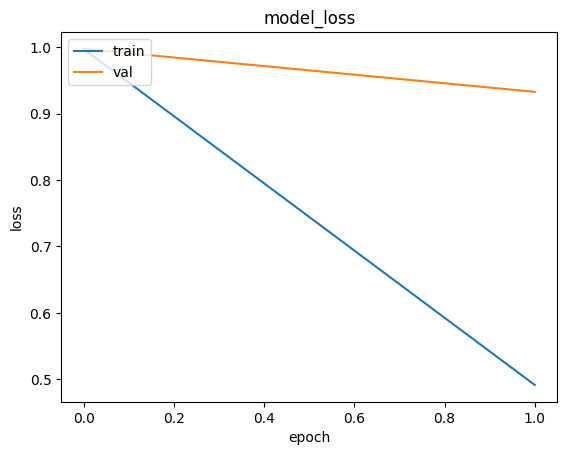

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

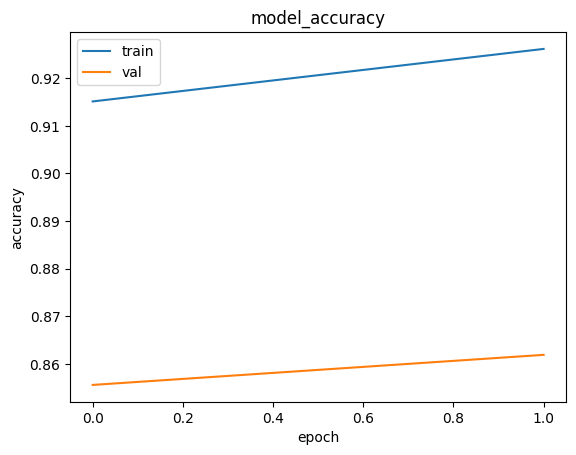

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Testing

In [28]:
index_to_word = { x:y for x,y in zip(range(len(french_vectorize_layer.get_vocabulary())),
                                     french_vectorize_layer.get_vocabulary()) }

In [ ]:
index_to_word

In [29]:
def translator(english_sentence):
    tokenized_english_sentence = english_vectorize_layer([english_sentence])
    # print(tokenized_english_sentence.shape)
    shifted_target = 'starttoken'
    
    for i in range(FRENCH_SEQUENCE_LENGTH):
    # for i in range(1):
        tokenized_shifed_target = french_vectorize_layer([shifted_target])
        output = seq2seq_gru.predict([tokenized_english_sentence, tokenized_shifed_target])
        french_word_index = tf.argmax(output, axis=-1)[0][i].numpy()
        current_word = index_to_word[french_word_index]

        if current_word == 'endtoken':
            break

        shifted_target += ' ' + current_word
        # print(shifted_target)
    
    return shifted_target[11:]

In [30]:
translator('have you ever watched a soccer match under the rain?')

1/1 [==============================] - 0s 25ms/step


'tu es [UNK]'

# BLEU

In [102]:
class BLEU(tf.keras.metrics.Metric):
    # No Brevity Penalty
    def __init__(self, name='bleu_score'):
        super().__init__()
        self.bleu_score = 0

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        self.bleu_score = 0
        for i, j in zip(y_pred, y_true): # iterate through items in batch
            tf.autograph.experimental.set_loop_options()
            total_word = tf.math.count_nonzero(i)
            total_matches = 0
            for word in i:
                if word == 0:
                    break
                for q in range(len(j)):
                    if j[q] == 0:
                        break
                    if j[q] == word:
                        total_matches += 1
                        j = tf.boolean_mask(j, [False if y == q else True for y in range(len(j))])
                        break
                        
            self.bleu_score += total_matches / total_word

    def result(self):
        return self.bleu_score / BATCH_SIZE

In [103]:
seq2seq_gru.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=[BLEU(),],
    run_eagerly=True
)

In [104]:
history = seq2seq_gru.fit(train_dataset, epochs=2, validation_data=val_dataset)

Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: not enough values to unpack (expected 2, got 0)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: not enough values to unpack (expected 2, got 0)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: not enough values to unpack (expected 2, got 0)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
    114/Unknown - 92s 808ms/step - loss: 0.2684 - bleu_4: 0.3514

KeyboardInterrupt: 